In [1]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import compute_sample_weight
import pandas as pd
import numpy as np
import mlrose as ml
from collections import defaultdict
from time import clock
import sklearn.model_selection as ms


In [2]:
# GET THE DATA ============

# wine data
file_path ="./data/"
wine = pd.read_csv (file_path+'wines.csv', sep =",")

# Break out predicting and target variable data    
wineX = wine.drop('quality',1).copy().values
wineY = wine['quality'].copy().values


In [3]:
#check the data
wineX.shape, wineY.shape

((6497, 12), (6497,))

In [5]:
# DIVIDE INTO TRAIN AND TEST SETS  
wine_trgX, wine_tstX, wine_trgY, wine_tstY = ms.train_test_split(
    wineX, wineY, test_size=0.3, random_state=0,stratify=wineY)     

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# scale the data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(wine_trgX)
X_test = scaler.transform(wine_tstX)
y_train = scaler.fit_transform(wine_trgY.reshape(-1, 1))
y_test = scaler.transform(wine_tstY.reshape(-1, 1))


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
#check the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4547, 12), (1950, 12), (4547, 1), (1950, 1))

In [8]:
# FIND BEST PARAMS

# find paramter values to iterate thru
#alphas = [10**-x for x in np.arange(1,4.01,1/2)]
alphas = [1.0, 0.5, 0.3, 0.1, .001, .00001]
dw = wineX.shape[1]
hiddens_wine = [[h,]*l for l in [1,2,3] for h in [dw,dw//2,round(dw/4),dw*2]]

paramdict = {'activation':['relu', 'sigmoid'],'learning_rate':alphas,'hidden_nodes':hiddens_wine, 
              'max_iters':[100], 'clip_max':[3,5], 'max_attempts': [10,20,50]}


In [9]:
hiddens_wine

[[12],
 [6],
 [3],
 [24],
 [12, 12],
 [6, 6],
 [3, 3],
 [24, 24],
 [12, 12, 12],
 [6, 6, 6],
 [3, 3, 3],
 [24, 24, 24]]

In [ ]:
# implementing a brute force "homemade" GridSearch
import mlrose as ml
from itertools import combinations
from sklearn.metrics import accuracy_score
import itertools

RandHC_Reg = []
algo_filename= RandHC
algo = 'random_hill_climb' 
# get all the different combinations of parameters
keys, values = zip(*paramdict.items())
params = [dict(zip(keys, v)) for v in itertools.product(*values)]

i=0
while i in range (0, len(params)):
                act = params[i]['activation']
                node = params[i]['hidden_nodes']
                learn = params[i]['learning_rate']
                times = params[i]['max_iters']
                clip = params[i]['clip_max']
                attempt = params[i]['max_attempts']
                
                
                print('Starting experiment {} of {}...'.format(i,len(params)))
                #print('Parameters of experiment {} are:'.format(i, params[i]))
                #print(params[i])
                
                np.random.seed(55)

                nn_rose = ml.NeuralNetwork(hidden_nodes = node, activation = act, 
                         algorithm = algo, max_iters = times, 
                         bias = False, is_classifier = True, learning_rate = learn, 
                         early_stopping = True, clip_max = clip, max_attempts = attempt)
                
                # start the clock - training
                st = clock()
                # fit the model
                nn_rose.fit(X_train, y_train)
                
                # Predict labels for train set and assess accuracy
                y_train_pred = nn_rose.predict(X_train)
                train_accuracy = accuracy_score(y_train, y_train_pred)
                # stop train time, save time elapsed
                train_time = clock()-st
                
                print('Training Accuracy of experiment {} is {}'.format(i,round(train_accuracy, 6)))
                print('Time to train = {}'.format(train_time))
                
                # start the clock - testing
                st = clock()
                # Predict labels for test set and assess accuracy
                y_test_pred = nn_rose.predict(X_test)
                test_accuracy = accuracy_score(y_test, y_test_pred)
                # stop test clock and save time elapsed
                test_time= clock()-st
                print('Test Accuracy of experiment {} is {}'.format(i,round(test_accuracy, 6)))
                print('Time to test = {}'.format(test_time))
                
                print('--------')

                results = (i, train_time, test_time, train_accuracy, test_accuracy, act, node, learn, times, clip, attempt, 
                          nn_rose.loss, nn_rose.node_list)
                RandHC_Reg.append(results)
                  
                

               
                # iterate  
                i+=1

#save the results and export
regTable = pd.DataFrame(RandHC_Reg)
# rename the columns
regTable.columns = ['Run_no', 'train_time', 'test_time', 'train_accuracy', 'test_accuracy', 'activation', 'hidden_nodes', 
                    'learning_rate', 'max_iter', 'clip_max', 'max_attempts', 'loss', 'node_list']
regTable.to_csv('./output/{}_reg.csv'.format("RandHC"),index=False)
                        

In [12]:
#save the results and export
regTable = pd.DataFrame(RandHC_Reg)
# rename the columns
regTable.columns = ['Run_no', 'train_time', 'test_time', 'train_accuracy', 'test_accuracy', 'activation', 'hidden_nodes', 
                    'learning_rate', 'max_iter', 'clip_max', 'max_attempts', 'loss', 'node_list']
regTable.to_csv('./output/{}_reg.csv'.format("RandHC"),index=False)
                        

In [ ]:
# find parameters that max test accuracy and minimize train time and 
regTable['test_accuracy'].max()
bestacc = regTable.loc[regTable['test_accuracy'].idxmax()]

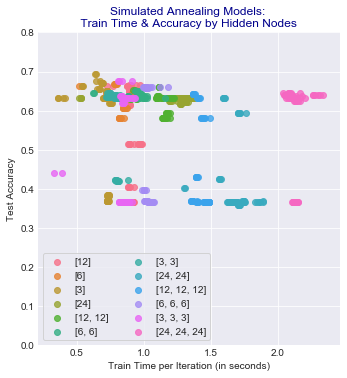

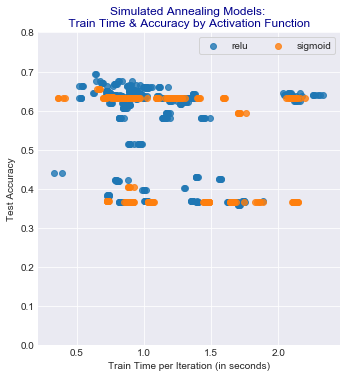

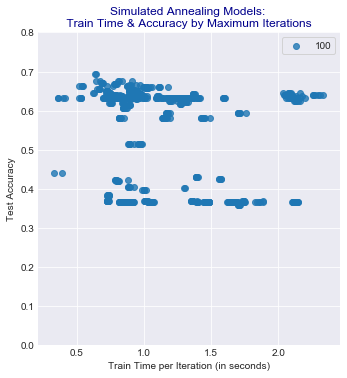

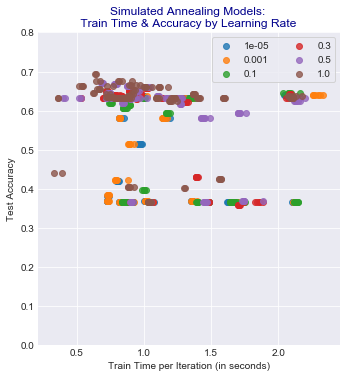

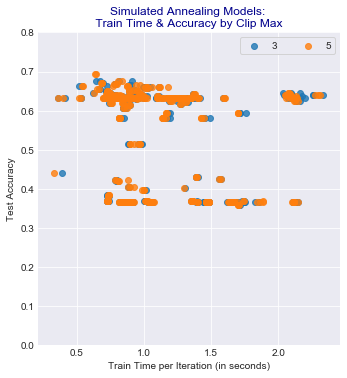

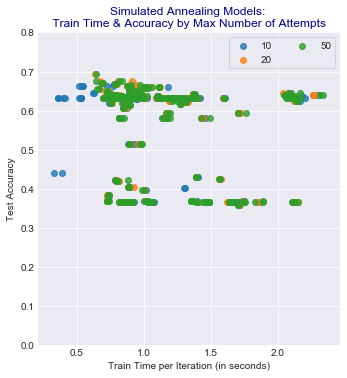

In [39]:
# RandHC - Scatterplots - Time vs Accuracy for different values of:
# hidden_nodes,  activation,  max_iters, learning_rate = learn, clip_max, max_attempts
# ==================================


import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

# style
plt.style.use('seaborn-darkgrid')
# create a color palette
palette = plt.get_cmap('Set1')


models = ['RandHC']
datasets = ['wine'] #, 'credit']
#param = 'param_KNN__n_neighbors'
params = ['hidden_nodes',  'activation',  'max_iter', 'learning_rate', 'clip_max', 'max_attempts']
img_name = ['hidden_nodes',  'activation',  'max_iter', 'learning_rate', 'clip_max', 'max_attempts']
axis = ["Hidden Nodes", "Activation Function", 'Maximum Iterations', 'Learning Rate', 'Clip Max', "Max Number of Attempts"]

for model in models:
    for ds in datasets:
        for i in range(0, len(params)):
            param = params[i]
            # get the data
            file = './output/'+model+'_reg.csv' 
            reg = pd.read_csv (file, sep =",")
            
            # Use the 'hue' argument to provide a factor variable
            sns.lmplot( x="train_time", y="test_accuracy", data=reg, fit_reg=False, hue=param, 
                       legend=False)
 
            # Move the legend to an empty part of the plot
            plt.legend(loc='lower right')
            plt.title('Simulated Annealing Models: \n Train Time & Accuracy by '+axis[i]+' ', loc='center', fontsize=12, fontweight=0, color='darkblue')
            plt.xlabel('Train Time per Iteration (in seconds)')
            plt.ylabel('Test Accuracy')
            plt.ylim(ymax = .8, ymin =0)
            plt.legend(loc='best', ncol=2, frameon=True) #, framealpha=2.0)
            plt.xticks(rotation=0)
            plt.savefig('./images/'+model+'_time_vs_acc _'+img_name[i]+'.png')
            plt.show()
            #plt.close()
            i+=1


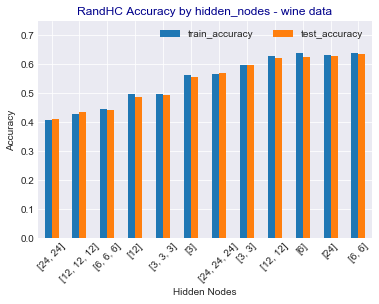

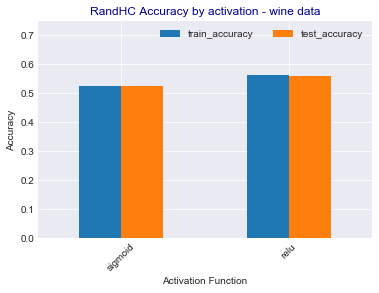

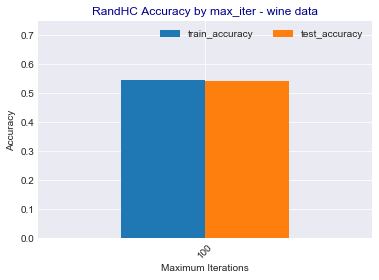

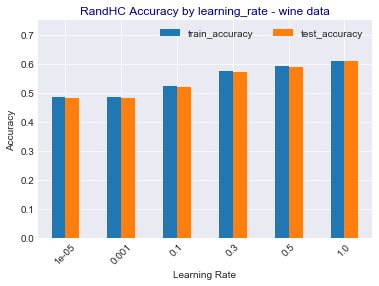

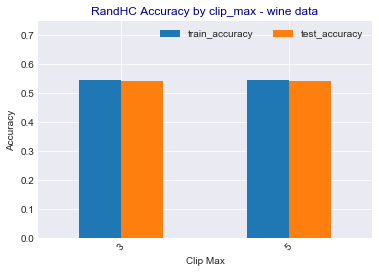

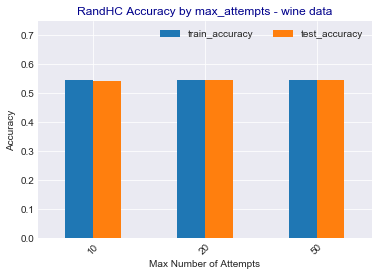

In [15]:
# RandHC - BAR CHART - Accuracy for different values of learn rate, population, and mutation prob ===================
models = ['RandHC']
datasets = ['wine'] #, 'credit']
#param = 'param_KNN__n_neighbors'
params = ['hidden_nodes',  'activation',  'max_iter', 'learning_rate', 'clip_max', 'max_attempts']
img_name = ['hidden_nodes',  'activation',  'max_iter', 'learning_rate', 'clip_max', 'max_attempts']
axis = ["Hidden Nodes", "Activation Function", 'Maximum Iterations', 'Learning Rate', 'Clip Max', "Max Number of Attempts"]


for model in models:
    for ds in datasets:
        for i in range(0, len(params)):
            param = params[i]
            # get the data
            file = './output/'+model+'_reg.csv' 
            reg = pd.read_csv (file, sep =",")
            # change param to group by to categorical variable
            reg[param] = reg[param].astype('category')
            # get mean test and train scores grouping by hidden layer
            reg_byHL = reg.groupby([param])['train_accuracy','test_accuracy'].mean()
            # sort values before plotting
            reg_byHL = reg_byHL.sort_values('test_accuracy')
            # plot it
            reg_byHL.plot.bar()
            #plt.ylim(ymax = 1.0, ymin =0)
            plt.title(model+' Accuracy by '+img_name[i]+' - '+ds+" data", loc='center', fontsize=12, fontweight=0, color='darkblue')
            plt.xlabel(axis[i])
            plt.ylabel('Accuracy')
            plt.ylim(ymax = 0.75, ymin =0)
            plt.legend(loc='best', ncol=2)
            plt.xticks(rotation=45)
            # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            #           fancybox=False, shadow=True, ncol=5)
            # plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
            #            ncol=2, mode="expand", borderaxespad=0.)

            plt.savefig('./images/'+model+'_'+ds+'_time_by_'+img_name[i]+'.png')
            plt.show()
            #plt.close()
            i+=1


In [16]:
# look at accuracy with 'best' parameters, using different max iterations
def mlrose_LC_iters(X,Y,clfName, algo):

    out = defaultdict(dict)
    iterations = [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 1000, 1500, 2000]
    for iters in iterations:
        X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=55)
        # scale the data
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train = scaler.fit_transform(y_train.reshape(-1, 1))
        y_test = scaler.transform(y_test.reshape(-1, 1))
        
        np.random.seed(55)
        nn_rose_iters = ml.NeuralNetwork(hidden_nodes = [24], 
                                activation = 'relu', 
                                algorithm = algo, 
                                max_iters = iters, 
                                #pop_size = 100, 
                                #mutation_prob = 0.3, 
                                bias = False, 
                                is_classifier = True, 
                                learning_rate = 0.1, 
                                early_stopping = False, 
                                clip_max = 3, 
                                max_attempts = 10)
        
        # start the clock - training
        st = clock()
        np.random.seed(55)
        nn_rose_iters.fit(X_train,y_train)
        # Predict labels for train set and assess accuracy
        y_train_pred = nn_rose_iters.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        # stop train time, save time elapsed
        out['train'][iters]= clock()-st
        out['train_acc'][iters] = train_accuracy
        
        # start the clock - testing
        st = clock()
        nn_rose_iters.predict(X_test)
        # Predict labels for test set and assess accuracy
        y_test_pred = nn_rose_iters.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        # stop test clock and save
        out['test'][iters]= clock()-st
        out['test_acc'][iters] = test_accuracy
        
        print(clfName,iters)
        print(test_accuracy)
        print(train_accuracy)
        print('------------')
    out = pd.DataFrame(out)
    out.to_csv('./output/{}_iters_LC.csv'.format(clfName))
    return 

In [17]:
mlrose_LC_iters(wineX, wineY, clfName='Rand_HC', algo = 'random_hill_climb')


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Rand_HC 10
0.616923076923
0.637098325957
------------
Rand_HC 20
0.616923076923
0.63729074466
------------
Rand_HC 30
0.616923076923
0.63729074466
------------
Rand_HC 40
0.616923076923
0.63729074466
------------
Rand_HC 50
0.616923076923
0.63729074466
------------
Rand_HC 100
0.617692307692
0.637675582067
------------
Rand_HC 150
0.617692307692
0.637483163363
------------
Rand_HC 200
0.617692307692
0.636905907254
------------
Rand_HC 250
0.617692307692
0.635751395036
------------
Rand_HC 300
0.616923076923
0.63228785838
------------
Rand_HC 350
0.619230769231
0.629593996536
------------
Rand_HC 400
0.616923076923
0.63478930152
------------
Rand_HC 450
0.62
0.635366557629
------------
Rand_HC 500
0.621538461538
0.633634789302
------------
Rand_HC 550
0.621538461538
0.635558976332
------------
Rand_HC 600
0.622307692308
0.636136232442
------------
Rand_HC 650
0.626153846154
0.634981720223
------------
Rand_HC 700
0.627692307692
0.637098325957
------------
Rand_HC 1000
0.658461538462
0.6

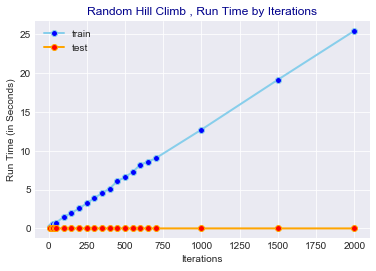

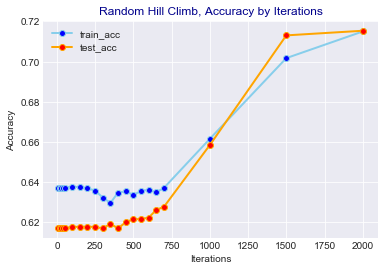

In [19]:
# Graph accuracy and timing by iterations =========

models = ['Rand_HC']
title = 'Random Hill Climb'
datasets = ['wine'] #, 'credit']
#param = 'param_KNN__n_neighbors'
# params = ['learning_rate', 'pop_size', 'mutation_prob', 'hidden_nodes']
# img_name = ['learn_rate', 'pop_size', 'mutate_prob', 'hidden_nodes']
# axis = ["Learning Rate", 'Population Size', "Mutation Probability", "Hidden Layers"]

for model in models:
    for s in datasets:
        #for p in portions:
        timing = []
        
        # get data
        file_path3 ="./output/"
        file_name = model+'_iters_LC.csv' 
        
        timing = pd.read_csv (file_path3+file_name, sep =",")
        timing['iters']= timing['Unnamed: 0']
        
        # plot timing number of iterations
        plt.plot( 'iters', 'train', data=timing, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
        plt.plot( 'iters', 'test', data=timing, marker='o', markerfacecolor='red', color='orange', linewidth=2)
        #plt.plot( 'fraction', 'y3', data=timing, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
        plt.title(title+" , Run Time by Iterations", loc='center', fontsize=12, fontweight=0, color='darkblue')
        plt.xlabel("Iterations")
        plt.ylabel("Run Time (in Seconds)")
        plt.legend()
        plt.savefig('images/'+model+'_time_iterations.png')
        plt.show()
        
        # plot accuracy by iterations
        plt.plot( 'iters', 'train_acc', data=timing, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
        plt.plot( 'iters', 'test_acc', data=timing, marker='o', markerfacecolor='red', color='orange', linewidth=2)
        #plt.plot( 'fraction', 'y3', data=timing, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
        plt.title(title+", Accuracy by Iterations", loc='center', fontsize=12, fontweight=0, color='darkblue')
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig('images/'+model+'_acc_iterations.png')
        plt.show()
        
        
        

In [20]:
# 2nd run
# zoom out and run it again to clarify results
def mlrose_LC_iters_2ndrun(X,Y,clfName, algo):

    out = defaultdict(dict)
    iterations = [500, 750, 1000, 1250, 1500, 1750, 2000, 3000, 4000, 5000]
    for iters in iterations:
        X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=55)
        # scale the data
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train = scaler.fit_transform(y_train.reshape(-1, 1))
        y_test = scaler.transform(y_test.reshape(-1, 1))
        
        np.random.seed(55)
        nn_rose_iters = ml.NeuralNetwork(hidden_nodes = [24], 
                                activation = 'relu', 
                                algorithm = algo, 
                                max_iters = iters, 
                                #pop_size = 100, 
                                #mutation_prob = 0.3, 
                                bias = False, 
                                is_classifier = True, 
                                learning_rate = 0.1, 
                                early_stopping = False, 
                                clip_max = 3, 
                                max_attempts = 10)
        
        # start the clock - training
        st = clock()
        np.random.seed(55)
        nn_rose_iters.fit(X_train,y_train)
        # Predict labels for train set and assess accuracy
        y_train_pred = nn_rose_iters.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        # stop train time, save time elapsed
        out['train'][iters]= clock()-st
        out['train_acc'][iters] = train_accuracy
        
        # start the clock - testing
        st = clock()
        nn_rose_iters.predict(X_test)
        # Predict labels for test set and assess accuracy
        y_test_pred = nn_rose_iters.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        # stop test clock and save
        out['test'][iters]= clock()-st
        out['test_acc'][iters] = test_accuracy
        
        print(clfName,iters)
        print(test_accuracy)
        print(train_accuracy)
        print('------------')
    out = pd.DataFrame(out)
    out.to_csv('./output/{}_iters_LC_2ndrun.csv'.format(clfName))
    return 

In [21]:
mlrose_LC_iters_2ndrun(wineX, wineY, clfName='RandHC', algo = 'simulated_annealing')

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


RandHC 500
0.614615384615
0.634596882817
------------
RandHC 750
0.618461538462
0.636328651145
------------
RandHC 1000
0.618461538462
0.635366557629
------------
RandHC 1250
0.611538461538
0.630556090052
------------
RandHC 1500
0.609230769231
0.620742736194
------------
RandHC 1750
0.617692307692
0.630940927458
------------
RandHC 2000
0.62
0.632865114489
------------
RandHC 3000
0.650769230769
0.660765826438
------------
RandHC 4000
0.681538461538
0.676351741389
------------
RandHC 5000
0.693076923077
0.707715989994
------------


In [22]:
#graph the results of the 2nd run

def timing_graphs_2ndrun(model, title, dataset):
    # graph accuracy and timing by iterations
    # graph accuracy by iterations
#     models = ['SimAnneal']
#     title = 'Simulated Annealing'
    dataset = s
    #param = 'param_KNN__n_neighbors'
    # params = ['learning_rate', 'pop_size', 'mutation_prob', 'hidden_nodes']
    # img_name = ['learn_rate', 'pop_size', 'mutate_prob', 'hidden_nodes']
    # axis = ["Learning Rate", 'Population Size', "Mutation Probability", "Hidden Layers"]

    #for model in models:
        #for s in datasets:
            #for p in portions:
    timing = []

    # get data
    file_path3 ="./output/"
    file_name = model+'_iters_LC_2ndrun.csv' 

    timing = pd.read_csv (file_path3+file_name, sep =",")
    timing['iters']= timing['Unnamed: 0']

    # plot timing number of iterations
    plt.plot( 'iters', 'train', data=timing, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'iters', 'test', data=timing, marker='o', markerfacecolor='red', color='orange', linewidth=2)
    #plt.plot( 'fraction', 'y3', data=timing, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
    plt.title(title+", Run Time by Iterations", loc='center', fontsize=12, fontweight=0, color='darkblue')
    plt.xlabel("Iterations")
    plt.ylabel("Run Time (in Seconds)")
    plt.legend()
    plt.savefig('images/'+model+'_time_iterations_2ndrun.png')
    plt.show()

    # plot accuracy by iterations
    plt.plot( 'iters', 'train_acc', data=timing, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'iters', 'test_acc', data=timing, marker='o', markerfacecolor='red', color='orange', linewidth=2)
    #plt.plot( 'fraction', 'y3', data=timing, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
    plt.title(title+", Accuracy by Iterations", loc='center', fontsize=12, fontweight=0, color='darkblue')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('images/'+model+'_acc_iterations_2ndrun.png')
    plt.show()
    return

        

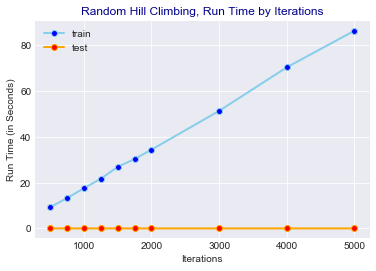

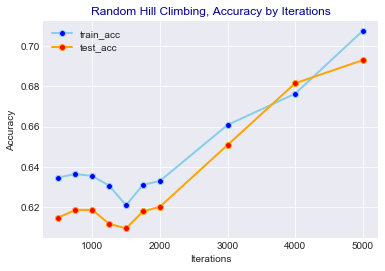

In [23]:
timing_graphs_2ndrun(model = 'RandHC', title = 'Random Hill Climbing', dataset='wine')

In [28]:
# define best paramters for simulated annealing algorithm
algo = 'random_hill_climb'
np.random.seed(55)
nn_rose_best = ml.NeuralNetwork(hidden_nodes = [6], 
                                activation = 'relu', 
                                algorithm = algo, 
                                max_iters = 4000, #  determined as best accuracy with least train time 
                                #pop_size = 100, 
                                #mutation_prob = 0.3, 
                                bias = False, 
                                is_classifier = True, 
                                learning_rate = 1, 
                                early_stopping = False, 
                                clip_max = 3, 
                                max_attempts = 10)
                

In [29]:
# define timing curve function using model with best parameters

from time import clock
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict


def mlrose_TimingCurve(X,Y,clfName,dataset):

    out = defaultdict(dict)
    for frac in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:    
        X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=frac, random_state=55)
        # scale the data
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train = scaler.fit_transform(y_train.reshape(-1, 1))
        y_test = scaler.transform(y_test.reshape(-1, 1))
        
        # start the clock - training
        st = clock()
        np.random.seed(55)
        nn_rose_best.fit(X_train,y_train)
        # Predict labels for train set and assess accuracy
        y_train_pred = nn_rose_best.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        # stop train time, save time elapsed
        out['train'][frac]= clock()-st
        out['train_acc'][frac] = train_accuracy
        
        # start the clock - testing
        st = clock()
        nn_rose_best.predict(X_test)
        # Predict labels for test set and assess accuracy
        y_test_pred = nn_rose_best.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        # stop test clock and save
        out['test'][frac]= clock()-st
        out['test_acc'][frac] = test_accuracy
        
        print(clfName,dataset,frac)
    out = pd.DataFrame(out)
    out.to_csv('./output/{}_{}_timing.csv'.format(clfName,dataset))
    return 

In [30]:
mlrose_TimingCurve(wineX, wineY, clfName='RandHC', dataset='wine')

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


RandHC wine 0.1
RandHC wine 0.2
RandHC wine 0.3
RandHC wine 0.4
RandHC wine 0.5
RandHC wine 0.6
RandHC wine 0.7
RandHC wine 0.8
RandHC wine 0.9


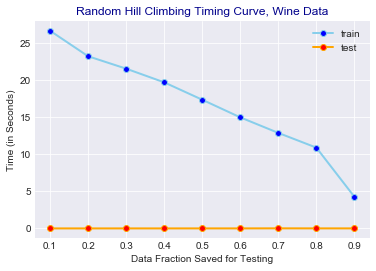

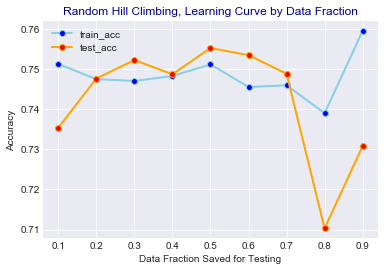

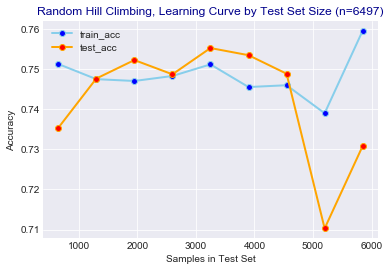

In [40]:
# Graph timing curve results to determine best data fraction for testing ================================

# multiple line plot
# style
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')


# Create a loop and save the resulting graphs
models = ['RandHC']
title = 'Random Hill Climbing'
datasets = ['wine']
#portions = ['training', 'test':

for model in models:
    for s in datasets:
        #for p in portions:
        timing = []
        
        # get data
        file_path3 ="./output/"
        file_name = model+'_wine_timing.csv' 
        
        timing = pd.read_csv (file_path3+file_name, sep =",")
        timing['fraction']= timing['Unnamed: 0']
        #timing['sample size'] = df.apply (lambda row: timing['fraction']*6497 (row),axis=1)
        # convert frac of data to sample size
        timing['test samples'] = timing['fraction'].apply(lambda x: round(x*6497))
        
        
        # plot timing by fraction of data
        plt.plot( 'fraction', 'train', data=timing, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
        plt.plot( 'fraction', 'test', data=timing, marker='o', markerfacecolor='red', color='orange', linewidth=2)
        #plt.plot( 'fraction', 'y3', data=timing, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
        plt.title(title+" Timing Curve, Wine Data", loc='center', fontsize=12, fontweight=0, color='darkblue')
        plt.xlabel("Data Fraction Saved for Testing")
        plt.ylabel("Time (in Seconds)")
        plt.legend()
        plt.savefig('images/'+model+'_TimingCurve.png')
        plt.show()
        
        # plot accuracy by fractions of data
        plt.plot( 'fraction', 'train_acc', data=timing, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
        plt.plot( 'fraction', 'test_acc', data=timing, marker='o', markerfacecolor='red', color='orange', linewidth=2)
        #plt.plot( 'fraction', 'y3', data=timing, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
        plt.title(title+", Learning Curve by Data Fraction", loc='center', fontsize=12, fontweight=0, color='darkblue')
        plt.xlabel("Data Fraction Saved for Testing")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig('images/'+model+'_LC_datafrac.png')
        plt.show()
        
        # plot accuracy by sample size
        plt.plot( 'test samples', 'train_acc', data=timing, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
        plt.plot( 'test samples', 'test_acc', data=timing, marker='o', markerfacecolor='red', color='orange', linewidth=2)
        #plt.plot( 'fraction', 'y3', data=timing, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
        plt.title(title+", Learning Curve by Test Set Size (n=6497)", loc='center', fontsize=12, fontweight=0, color='darkblue')
        plt.xlabel("Samples in Test Set")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig('images/'+model+'_LC_samplesize.png')
        plt.show()

        

In [37]:
# best data fraction for testing = 0.3
# run the final model with best params, best ieters, and best train/test split



def mlrose_SA_finalmodel(X,Y,clfName,algo):
    out = defaultdict(dict)
    # split the data according to best data frac 
    X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.3, random_state=55)
    # scale the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = scaler.fit_transform(y_train.reshape(-1, 1))
    y_test = scaler.transform(y_test.reshape(-1, 1))

    np.random.seed(55)
    nn_rose_final = ml.NeuralNetwork(hidden_nodes = [6], 
                            activation = 'relu', 
                            algorithm = algo, 
                            max_iters = 4000, 
                            #pop_size = 100, 
                            #mutation_prob = 0.3, 
                            bias = False, 
                            is_classifier = True, 
                            learning_rate = 1, 
                            early_stopping = False, 
                            clip_max = 3, 
                            max_attempts = 10)

    # start the clock - training
    st = clock()
    np.random.seed(55)
    nn_rose_final.fit(X_train,y_train)
    # Predict labels for train set and assess accuracy
    y_train_pred = nn_rose_final.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    # stop train time, save time elapsed
    out['train_time'][0]= clock()-st
    out['train_acc'][0]= train_accuracy

    # start the clock - testing
    st = clock()
    nn_rose_final.predict(X_test)
    # Predict labels for test set and assess accuracy
    y_test_pred = nn_rose_final.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    # stop test clock and save
    out['test_time'][0]= clock()-st
    out['test_acc'][0] = test_accuracy
    #weights = nn_rose_final.weights
    print(clfName, "final model")
    print(test_accuracy)
    print(train_accuracy)
    print('------------')
    out = pd.DataFrame(out)
    out.to_csv('./output/{}_final.csv'.format(clfName))
    return


In [38]:
mlrose_SA_finalmodel(wineX, wineY, clfName='RandHC', algo = 'random_hill_climb')

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


RandHC final model
0.752307692308
0.747085990763
------------


In [34]:
nn_rose_final.weights

NameError: name 'nn_rose_final' is not defined